In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import mplfinance as mpf
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from datetime import datetime as dt
from typing import \
    List, \
    Dict, \
    Callable


In [78]:
system_201_dir = '/Users/mbz/Documents/environments_local/system201'
features_dir = 'var/osprey_indicators'
asset_class_name = 'Energies'
symbol = 'CL'
data_file_dir = '{}/{}/{}/{}'.format(system_201_dir, features_dir, asset_class_name, symbol)
# file_name_pattern_list = [
#     '{}.base.core.gp_train_set.csv',
#     '{}.base.technical.gp_train_set.csv',
#     '{}.base.returns.gp_train_set.csv',
#     '{}.base.carry.gp_train_set.csv',
#     '{}.base.seasonality.gp_train_set.csv'
# ]
# # core_df = pd.read_csv('{}/CL.base.core.gp_train_set.csv'.format(data_file_dir))

# df_list = []
# for file_name_pattern in file_name_pattern_list:
#     file_name = file_name_pattern.format(symbol)
#     df = pd.read_csv(data_file_dir + '/' + file_name,
#                      index_col=0,
#                      header=0,
#                      parse_dates=[0],
#                      date_format="%Y-%m-%d")
#     df.columns = [col.strip() for col in df.columns]
#     df_clean = df
#     # df_clean.columns = [name+'.'+col_name for col_name in df_clean.columns]
#     df_list.append(df_clean)

# # assemble df's from all files into a single df
# final_df = pd.concat(df_list, axis=1, join='inner')
# final_df = final_df.loc[:,~final_df.columns.duplicated()].copy()


final_df = pd.read_csv(data_file_dir + '/{}.DOHLCviVIAF.csv'.format(symbol), 
                 index_col=0, 
                 header=0,
                 parse_dates=[0],
                 date_format='%Y-%m-%d')
final_df.columns = [col.strip().upper() for col in final_df.columns]



In [ ]:
final_df['FILENAME'] = final_df['FILENAME'].str.replace('CL_FUT.', '')
final_df['FILENAME'] = final_df['FILENAME'].str.replace('.csv', '')

final_df.drop(['CONTRACTVOLUME', 'TOTALVOLUME', 'CONTRACTOPENINTEREST', 'TOTALOPENINTEREST'], axis=1, inplace=True)


In [ ]:
final_df.columns = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ORG_CLONE', 'DEL_MOS']
final_df


In [ ]:
final_df.to_csv('CL.csv', date_format='%Y-%m-%d')


In [79]:
# our signals are based on the close
final_df['close_log_ret'] = np.log(final_df['CLOSE']) - np.log(final_df['CLOSE'].shift(1))

# calculate the vol, inclusing a short vol and a long vol floor
final_df['close_log_ret_sqr'] = final_df['close_log_ret'] * final_df['close_log_ret']
final_df['close_log_ret_sqr_short'] = final_df['close_log_ret_sqr'].ewm(span=42, min_periods=42).mean()
final_df['close_vol_short'] = final_df['close_log_ret_sqr_short'].pow(0.5)
final_df['close_log_ret_sqr_long'] = final_df['close_log_ret_sqr'].ewm(span=504, min_periods=42).mean()
final_df['close_vol_long'] = final_df['close_log_ret_sqr_long'].pow(0.5)
final_df['close_vol'] = final_df[['close_vol_short', 'close_vol_long']].max(axis=1)
final_df['close_ret_sr'] = final_df['close_log_ret'] / final_df['close_vol']


# EWMAC_32_128
final_df['close_ewma_32'] = final_df['CLOSE'].ewm(span=32, min_periods=32).mean()
final_df['close_ewma_128'] = final_df['CLOSE'].ewm(span=128, min_periods=128).mean()
final_df['close_ewmac_32_128'] = final_df['close_ewma_32'] - final_df['close_ewma_128']
final_df['close_ewmac_32_128_nvol'] = final_df['close_ewmac_32_128'] / final_df['close_vol']

final_df.columns


Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'CONTRACTVOLUME', 'TOTALVOLUME',
       'CONTRACTOPENINTEREST', 'TOTALOPENINTEREST', 'ADJCLOSE', 'FILENAME',
       'close_log_ret', 'close_log_ret_sqr', 'close_log_ret_sqr_short',
       'close_vol_short', 'close_log_ret_sqr_long', 'close_vol_long',
       'close_vol', 'close_ret_sr', 'close_ewma_32', 'close_ewma_128',
       'close_ewmac_32_128', 'close_ewmac_32_128_nvol'],
      dtype='object')

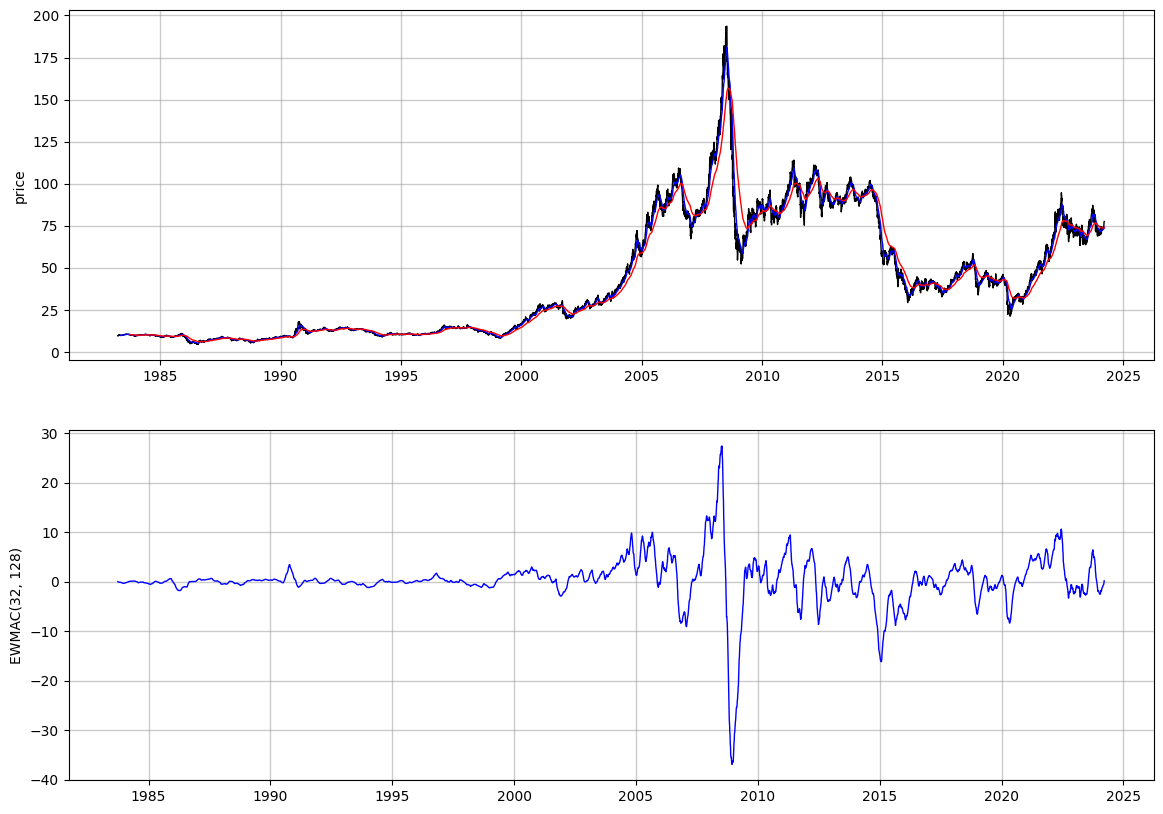

In [80]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
# plt.title( '{}: Stage Two Model SR: {:4.3f}'.format(symbol, stage_2_sr), fontsize=15)

ax1.plot(final_df['CLOSE'], color='black', linewidth='1')
ax1.plot(final_df['close_ewma_32'], color='blue', linewidth='1')
ax1.plot(final_df['close_ewma_128'], color='red', linewidth='1')
ax1.set_ylabel('price')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax2.plot(final_df['close_ewmac_32_128'], color='blue', linewidth='1')
ax2.set_ylabel('EWMAC(32, 128)')
ax2.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

# plt.ylabel("log equity")
# plt.legend()
plt.show()


In [81]:
# EWMAC_32_128_NVOL
final_df['close_log_ret_sr_cumsum'] = final_df['close_ret_sr'].cumsum()
final_df['close_lsr_ewma_32'] = final_df['close_log_ret_sr_cumsum'].ewm(span=32, min_periods=32).mean()
final_df['close_lsr_ewma_128'] = final_df['close_log_ret_sr_cumsum'].ewm(span=128, min_periods=128).mean()
final_df['close_lsr_ewmac_32_128'] = final_df['close_lsr_ewma_32'] - final_df['close_lsr_ewma_128']


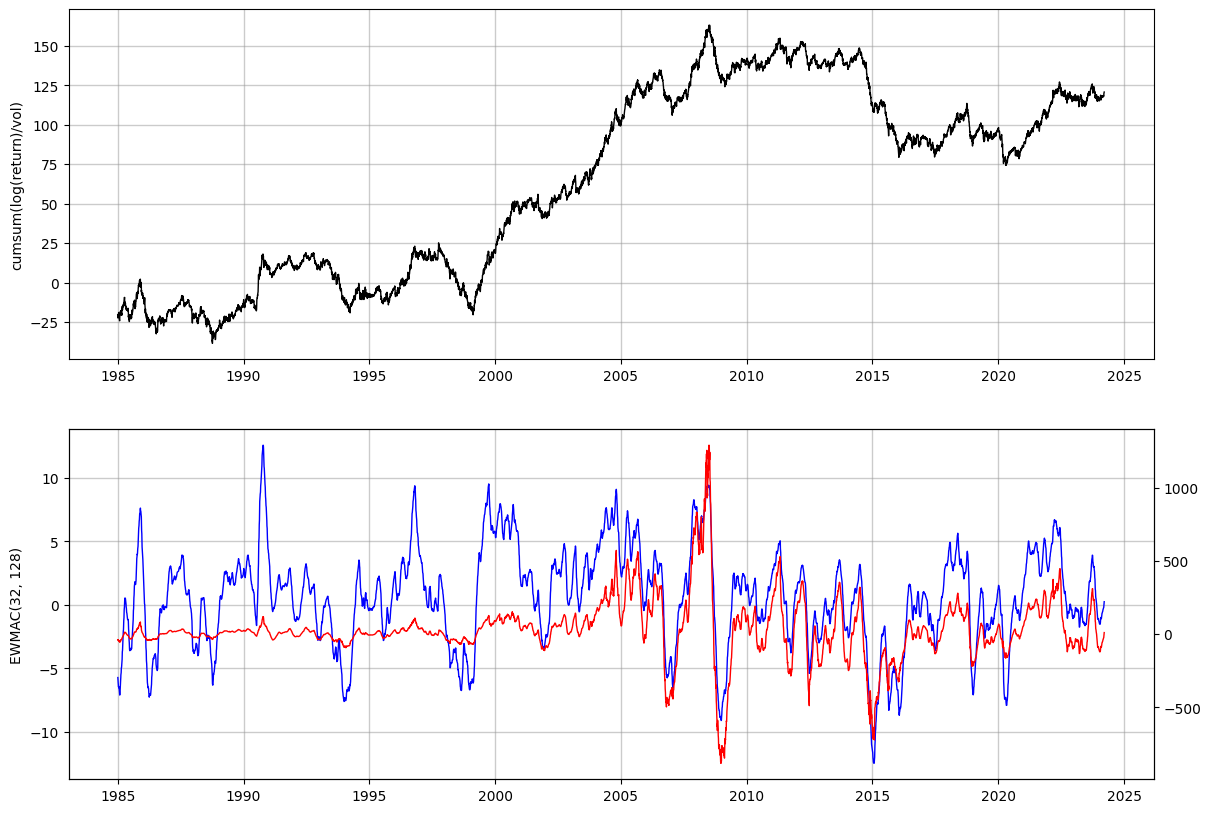

In [86]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
# plt.title( '{}: Stage Two Model SR: {:4.3f}'.format(symbol, stage_2_sr), fontsize=15)

ax1.plot(final_df['close_log_ret_sr_cumsum']['1985':], color='black', linewidth='1')
# ax1.plot(final_df['close_ewma_32'], color='blue', linewidth='1')
# ax1.plot(final_df['close_ewma_128'], color='red', linewidth='1')
ax1.set_ylabel('cumsum(log(return)/vol)')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax21 = ax2.twinx()
ax2.plot(final_df['close_lsr_ewmac_32_128']['1985':], color='blue', linewidth='1')
ax21.plot(final_df['close_ewmac_32_128_nvol']['1985':], color='red', linewidth='1')

ax2.set_ylabel('EWMAC(32, 128)')
ax2.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

plt.show()


In [67]:

# forward return is open to open
final_df['open_log_ret'] = np.log(final_df['OPEN']) - np.log(final_df['OPEN'].shift(1))
final_df['1df_open_log_ret'] = final_df['open_log_ret'].shift(-2)
# final_df

x_axis_col_name = 'close_lsr_ewmac_32_128'
y_axis_col_name = '1df_open_log_ret'



<Axes: xlabel='Count', ylabel='1df_open_log_ret'>

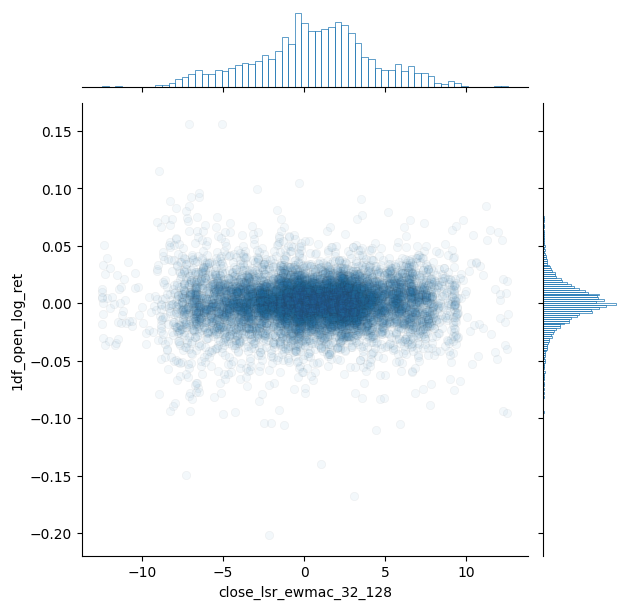

In [68]:

# plt.scatter(final_df[x_axis_col_name], final_df[y_axis_col_name], alpha=0.01)
# # plt.title('Year 2000')
# plt.xlabel(x_axis_col_name)
# plt.ylabel(y_axis_col_name)
# plt.show()


x, y = final_df[x_axis_col_name], final_df[y_axis_col_name]
g = sns.JointGrid()
sns.scatterplot(x=x, y=y, alpha=.05, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y)
# sns.lineplot(data=final_df, x=x_axis_col_name, y=x_axis_col_name, ax=g.ax_joint)


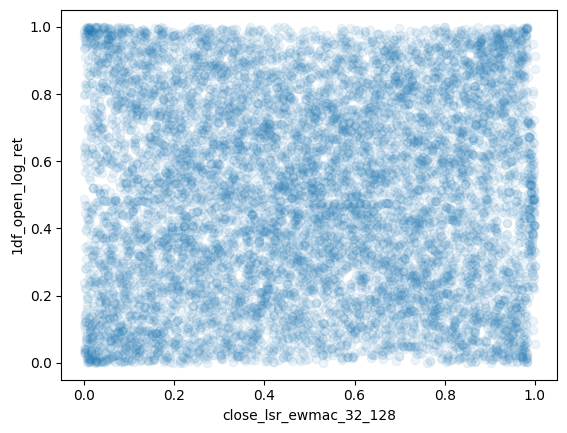

In [69]:
final_df.sort_values(by=[x_axis_col_name], inplace=True)
final_df['p_'+x_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)

final_df.sort_values(by=[y_axis_col_name], inplace=True)
final_df['p_'+y_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)



x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]
plt.scatter(x, y, alpha=0.08)
plt.xlabel(x_axis_col_name)
plt.ylabel(y_axis_col_name)
plt.show()


In [44]:
def create_y_hat_index(bin_col_name_list: List[str], bin_count: int) -> pd.Index:
    """
    This method creates an index that corresponds to the index returned by the
    binned_features_data_df.groupby(bin_col_name_list) call in base_model.fit()

    Unlike the index returned by the groupby() call, this index is guaranteed
    to not be missing any values; it completely spans the space of all bins in
    every dimension/feature

    :return: pd.Index
    """
    if len(bin_col_name_list) > 1:
        # calculate coordinates per each dimension
        dims_coordinates_list = []
        for d in range(len(bin_col_name_list)):
            # create an sequence of length mask_bin_counts[d]
            dim_coordinates = np.arange(bin_count)
            # store this sequence of distances for this dimension
            dims_coordinates_list.append(dim_coordinates)

        result = pd.MultiIndex.from_product(dims_coordinates_list, names=bin_col_name_list)
    else:
        # if we only have a single feature, then we are going to use a RangeIndex
        result = pd.RangeIndex(0, bin_count, 1, name=bin_col_name_list[0])

    return result


In [45]:
final_df.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'CONTRACTVOLUME', 'TOTALVOLUME',
       'CONTRACTOPENINTEREST', 'TOTALOPENINTEREST', 'ADJCLOSE', 'FILENAME',
       'close_log_ret', 'close_log_ret_sqr', 'close_log_ret_sqr_short',
       'close_vol_short', 'close_log_ret_sqr_long', 'close_vol_long',
       'close_vol', 'close_ret_sr', 'close_ewma_32', 'close_ewma_128',
       'close_ewmac_32_128', 'close_ewmac_32_128_nvol',
       'close_log_ret_sr_cumsum', 'close_lsr_ewma_32', 'close_lsr_ewma_128',
       'close_lsr_ewmac_32_128', 'open_log_ret', '1df_open_log_ret',
       'p_close_lsr_ewmac_32_128', 'p_1df_open_log_ret'],
      dtype='object')

In [46]:
bin_count = 10
bin_col_name_list = []

final_df.sort_index(inplace=True)

# bin x feature
x_bin_assignments, x_bin_edges = pd.qcut(final_df[x_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
x_bin_assignments_df = x_bin_assignments.to_frame()
x_bin_col_name = 'bins_' + x_axis_col_name
bin_col_name_list.append(x_bin_col_name)
x_bin_assignments_df.rename(columns={x_axis_col_name: x_bin_col_name}, inplace=True)

# bin y target
y_bin_assignments, y_bin_edges = pd.qcut(final_df[y_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
y_bin_assignments_df = y_bin_assignments.to_frame()
y_bin_col_name = 'bins_' + y_axis_col_name
bin_col_name_list.append(y_bin_col_name)
y_bin_assignments_df.rename(columns={y_axis_col_name: y_bin_col_name}, inplace=True)


# create data_frame with bins and target feature
binned_data_df = pd.concat([x_bin_assignments_df, y_bin_assignments_df], axis=1)
binned_data_df = binned_data_df.join(
    final_df[y_axis_col_name],
    how='right'
)
binned_data_df.dropna(axis=0, inplace=True)

# calculate the joint distribution
y_hats = binned_data_df.groupby(bin_col_name_list)[y_axis_col_name].count()
temp_y_hat_df = y_hats.to_frame()
temp_y_hat_df.columns = ['y_hat']
# y_hat_df = y_hat_df.reset_index()

y_hat_df = pd.DataFrame(index=create_y_hat_index(bin_col_name_list, bin_count))
y_hat_df['y_hat'] = temp_y_hat_df['y_hat']
y_hat_df = y_hat_df.reset_index()

<Axes: xlabel='p_close_lsr_ewmac_32_128', ylabel='p_1df_open_log_ret'>

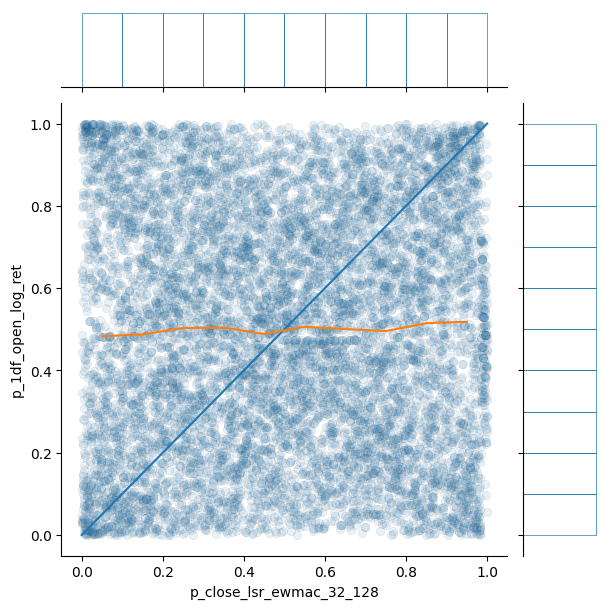

In [47]:
final_df[x_bin_col_name] = binned_data_df[x_bin_col_name]

# calculate the y_hat for each bin
y_hats = final_df.groupby(x_bin_col_name)['p_'+y_axis_col_name].mean()

g = sns.JointGrid()
sns.scatterplot(x=x, y=y, alpha=.1, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x, bins=10)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y, bins=10)
sns.lineplot(data=final_df, x='p_'+x_axis_col_name, y='p_'+x_axis_col_name, ax=g.ax_joint)
sns.lineplot(x=np.arange(0.05, 1.05, 0.1), y=y_hats, ax=g.ax_joint)

In [48]:
y_hat_pivot_df = y_hat_df.pivot(index=bin_col_name_list[1], columns=bin_col_name_list[0], values='y_hat')
y_hat_pivot_df = y_hat_pivot_df.iloc[::-1]
print(y_hat_pivot_df)


bins_close_lsr_ewmac_32_128    0    1    2    3    4    5    6    7    8    9
bins_1df_open_log_ret                                                        
9                            180  109   98   89   61   68   75   74  108  165
8                             96   95  103  108   87   82  100  117  117  120
7                             67  108   87  108  110  124  108  104  104   96
6                             68   78  110  111  107  120  101  107  110   94
5                             55   98  115  105  123  128  112   92   98   67
4                             69   85   96   97  119  129  131  104   89   66
3                             82  112  112  103  124  110  113  100   86   57
2                             99  100  112   92  106   98   96  121  102   86
1                            114   89   89   98  104   75  111  127   96  124
0                            182  138   90  101   69   77   65   66  102  137


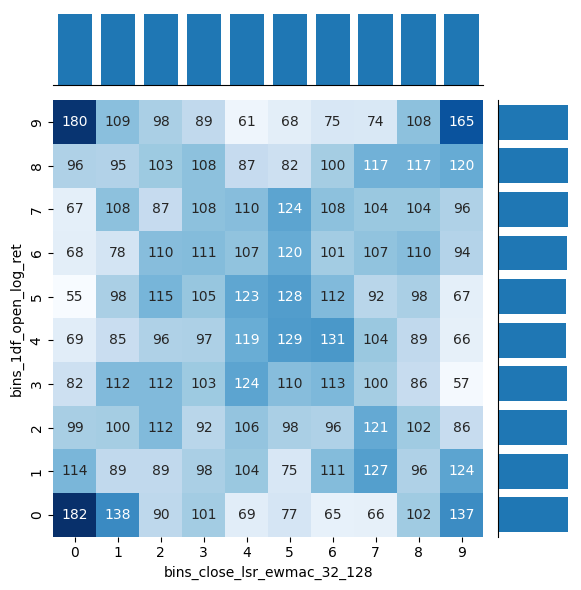

In [49]:
g = sns.jointplot(data=y_hat_df, 
                  x=bin_col_name_list[0], 
                  y=bin_col_name_list[1], 
                  kind='hist', 
                  bins=(len(bin_col_name_list[0]), len(bin_col_name_list[1])))
g.ax_marg_y.cla()
g.ax_marg_x.cla()
sns.heatmap(data=y_hat_pivot_df, ax=g.ax_joint, cbar=False, cmap='Blues', annot=True, fmt="d")
g.ax_marg_y.barh(np.arange(0.5, 10), y_hat_pivot_df.sum(axis=1)/len(bin_col_name_list[0]))
g.ax_marg_x.bar(np.arange(0.5, 10), y_hat_pivot_df.sum(axis=0)/len(bin_col_name_list[1]))

# remove ticks between heatmao and histograms
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# remove ticks showing the heights of the histograms
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

plt.show()

In [50]:
# calculate the joint distribution
y_hats = binned_data_df.groupby(x_bin_col_name)[y_axis_col_name].mean()
temp_y_hat_df = y_hats.to_frame()
temp_y_hat_df.columns = ['y_hat']
# y_hat_df = y_hat_df.reset_index()

# y_hat_df = pd.DataFrame(index=create_y_hat_index(bin_col_name_list, bin_count))
y_hat_df = temp_y_hat_df
y_hat_df['y_hat'] = temp_y_hat_df['y_hat']
y_hat_df = y_hat_df.reset_index()

<Axes: xlabel='bins_close_lsr_ewmac_32_128', ylabel='y_hat'>

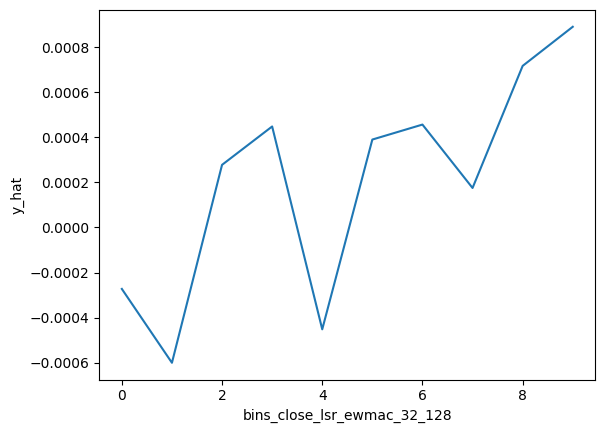

In [51]:
sns.lineplot(data=y_hat_df, x=x_bin_col_name, y='y_hat')


In [55]:

# y-axis is abs(forward return)
final_df['1df_open_log_ret_abs'] = final_df['1df_open_log_ret'].abs()
# final_df

x_axis_col_name = 'close_lsr_ewmac_32_128'
y_axis_col_name = '1df_open_log_ret_abs'



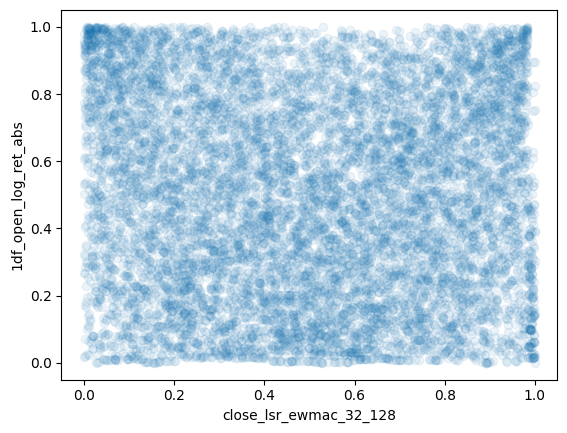

In [56]:
final_df.sort_values(by=[x_axis_col_name], inplace=True)
final_df['p_'+x_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)

final_df.sort_values(by=[y_axis_col_name], inplace=True)
final_df['p_'+y_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)



x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]
plt.scatter(x, y, alpha=0.08)
plt.xlabel(x_axis_col_name)
plt.ylabel(y_axis_col_name)
plt.show()


In [57]:
bin_count = 10
bin_col_name_list = []

final_df.sort_index(inplace=True)

# bin x feature
x_bin_assignments, x_bin_edges = pd.qcut(final_df[x_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
x_bin_assignments_df = x_bin_assignments.to_frame()
x_bin_col_name = 'bins_' + x_axis_col_name
bin_col_name_list.append(x_bin_col_name)
x_bin_assignments_df.rename(columns={x_axis_col_name: x_bin_col_name}, inplace=True)

# bin y target
y_bin_assignments, y_bin_edges = pd.qcut(final_df[y_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
y_bin_assignments_df = y_bin_assignments.to_frame()
y_bin_col_name = 'bins_' + y_axis_col_name
bin_col_name_list.append(y_bin_col_name)
y_bin_assignments_df.rename(columns={y_axis_col_name: y_bin_col_name}, inplace=True)


# create data_frame with bins and target feature
binned_data_df = pd.concat([x_bin_assignments_df, y_bin_assignments_df], axis=1)
binned_data_df = binned_data_df.join(
    final_df[y_axis_col_name],
    how='right'
)
binned_data_df.dropna(axis=0, inplace=True)

# calculate the joint distribution
y_hats = binned_data_df.groupby(bin_col_name_list)[y_axis_col_name].count()
temp_y_hat_df = y_hats.to_frame()
temp_y_hat_df.columns = ['y_hat']
# y_hat_df = y_hat_df.reset_index()

y_hat_df = pd.DataFrame(index=create_y_hat_index(bin_col_name_list, bin_count))
y_hat_df['y_hat'] = temp_y_hat_df['y_hat']
y_hat_df = y_hat_df.reset_index()

<Axes: xlabel='p_close_lsr_ewmac_32_128', ylabel='p_1df_open_log_ret_abs'>

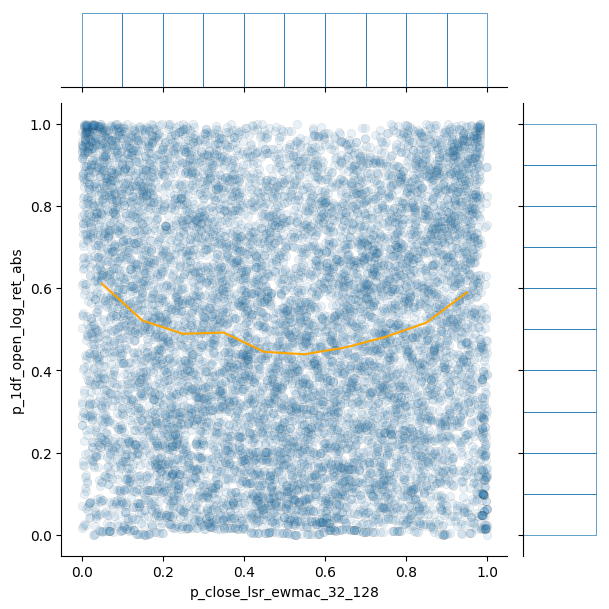

In [60]:
final_df[x_bin_col_name] = binned_data_df[x_bin_col_name]

# calculate the y_hat for each bin
y_hats = final_df.groupby(x_bin_col_name)['p_'+y_axis_col_name].mean()

g = sns.JointGrid()
sns.scatterplot(x=x, y=y, alpha=.1, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x, bins=10)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y, bins=10)
# sns.lineplot(data=final_df, x='p_'+x_axis_col_name, y='p_'+x_axis_col_name, ax=g.ax_joint)
sns.lineplot(x=np.arange(0.05, 1.05, 0.1), y=y_hats, color='orange', ax=g.ax_joint)

In [61]:
y_hat_pivot_df = y_hat_df.pivot(index=bin_col_name_list[1], columns=bin_col_name_list[0], values='y_hat')
y_hat_pivot_df = y_hat_pivot_df.iloc[::-1]
print(y_hat_pivot_df)


bins_close_lsr_ewmac_32_128    0    1    2    3    4    5    6    7    8    9
bins_1df_open_log_ret_abs                                                    
9                            221  122  105   85   59   63   54   55   96  169
8                            138  124   85  104   71   81   89   85  112  135
7                            118   85   99  103   92   79   94  107  118  131
6                             95  102   93  101   95   80  118  131  101  110
5                             79  110   98  106  109  108  101  115   95   99
4                             80   89   98   94  116  118  100  113  115   89
3                             72   93  101  127  111  116  112  108   92   73
2                             82   95  126   90  104  113  107  100  103   76
1                             57  104  117   91  125  118  117  105   99   63
0                             70   88   90  111  128  135  120   93   81   67


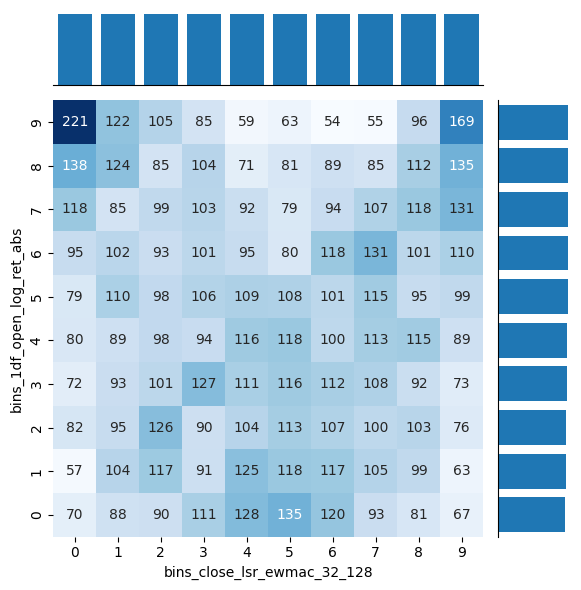

In [62]:
g = sns.jointplot(data=y_hat_df, 
                  x=bin_col_name_list[0], 
                  y=bin_col_name_list[1], 
                  kind='hist', 
                  bins=(len(bin_col_name_list[0]), len(bin_col_name_list[1])))
g.ax_marg_y.cla()
g.ax_marg_x.cla()
sns.heatmap(data=y_hat_pivot_df, ax=g.ax_joint, cbar=False, cmap='Blues', annot=True, fmt="d")
g.ax_marg_y.barh(np.arange(0.5, 10), y_hat_pivot_df.sum(axis=1)/len(bin_col_name_list[0]))
g.ax_marg_x.bar(np.arange(0.5, 10), y_hat_pivot_df.sum(axis=0)/len(bin_col_name_list[1]))

# remove ticks between heatmao and histograms
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# remove ticks showing the heights of the histograms
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

plt.show()

In [64]:
# calculate the joint distribution
y_hats = binned_data_df.groupby(x_bin_col_name)[y_axis_col_name].mean()
temp_y_hat_df = y_hats.to_frame()
temp_y_hat_df.columns = ['y_hat']
# y_hat_df = y_hat_df.reset_index()

# y_hat_df = pd.DataFrame(index=create_y_hat_index(bin_col_name_list, bin_count))
y_hat_df = temp_y_hat_df
y_hat_df['y_hat'] = temp_y_hat_df['y_hat']
y_hat_df = y_hat_df.reset_index()

<Axes: xlabel='bins_close_lsr_ewmac_32_128', ylabel='y_hat'>

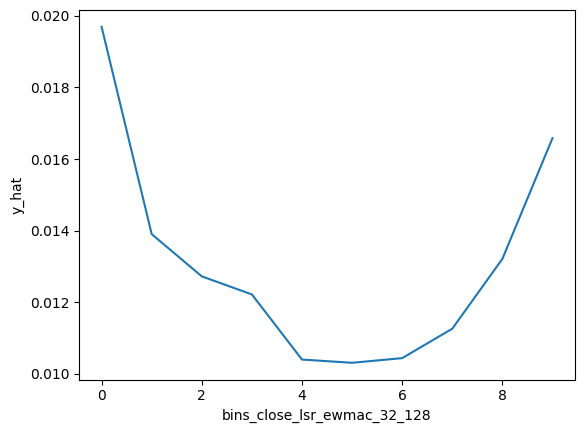

In [65]:
sns.lineplot(data=y_hat_df, x=x_bin_col_name, y='y_hat')


In [91]:
file_name_pattern_list = [
    '{}.base.core.gp_train_set.csv',
    '{}.base.technical.gp_train_set.csv',
    '{}.base.returns.gp_train_set.csv',
    '{}.base.carry.gp_train_set.csv',
    '{}.base.seasonality.gp_train_set.csv'
]
# core_df = pd.read_csv('{}/CL.base.core.gp_train_set.csv'.format(data_file_dir))

df_list = []
for file_name_pattern in file_name_pattern_list:
    file_name = file_name_pattern.format(symbol)
    df = pd.read_csv(data_file_dir + '/' + file_name,
                     index_col=0,
                     header=0,
                     parse_dates=[0],
                     date_format="%Y-%m-%d")
    df.columns = [col.strip() for col in df.columns]
    df_clean = df
    # df_clean.columns = [name+'.'+col_name for col_name in df_clean.columns]
    df_list.append(df_clean)

# assemble df's from all files into a single df
final_df = pd.concat(df_list, axis=1, join='inner')
final_df = final_df.loc[:,~final_df.columns.duplicated()].copy()


In [101]:
final_df.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'CONTRACTVOLUME', 'TOTALVOLUME',
       'CONTRACTOPENINTEREST', 'TOTALOPENINTEREST', 'ADJCLOSE', 'FILENAME',
       'close_log_ret', 'close_log_ret_sqr', 'close_log_ret_sqr_short',
       'close_vol_short', 'close_log_ret_sqr_long', 'close_vol_long',
       'close_vol', 'close_ret_sr', 'close_ewma_32', 'close_ewma_128',
       'close_ewmac_32_128', 'close_ewmac_32_128_nvol',
       'close_log_ret_sr_cumsum', 'close_lsr_ewma_32', 'close_lsr_ewma_128',
       'close_lsr_ewmac_32_128'],
      dtype='object')

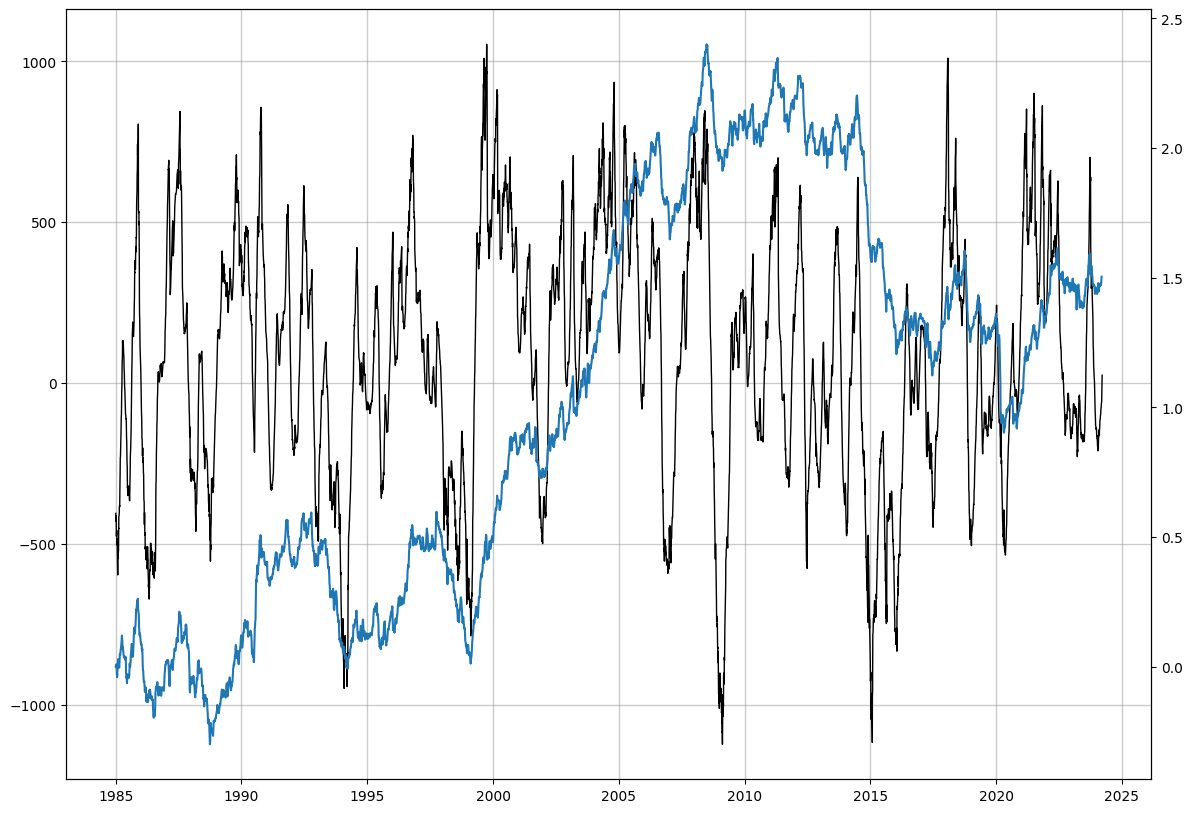

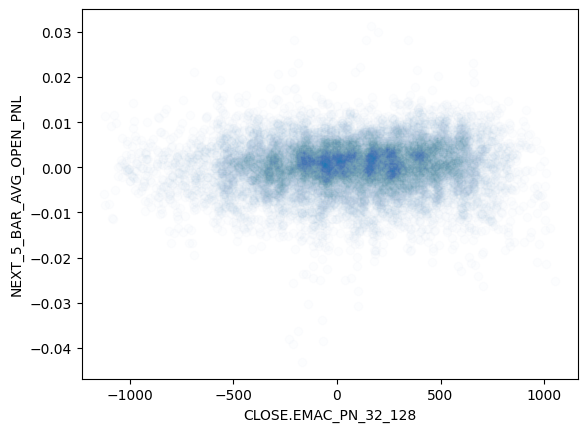

In [94]:
# x_axis_col_name = 'CLOSE.EMAC_PN_16_64'
# x_axis_col_name = 'CLOSE.PNL.EMA_32'
# x_axis_col_name = 'CLOSE.PNL_N.EMA_32'
# x_axis_col_name = 'CLOSE.PNL_N.EMA_64'
# x_axis_col_name = 'CLOSE.PNL_N.EMA_128'
# x_axis_col_name = 'CLOSE.PNL.EMA_128'
x_axis_col_name = 'CLOSE.EMAC_PN_32_128'
# x_axis_col_name = 'days_of_year'
# x_axis_col_name = 'CARRY.EMA_4.SR.ZSCORE_32'

y_axis_col_name = 'NEXT_5_BAR_AVG_OPEN_PNL'
# y_axis_col_name = 'NEXT_20_BAR_AVG_PNL'
# y_axis_col_name = 'NEXT_BAR_OPEN_PNL'
# y_axis_col_name = 'NEXT_BAR_RAW_PNL'



fig, ax1 = plt.subplots(figsize=(14, 10))
# plt.title( '{}: Stage Two Model SR: {:4.3f}'.format(symbol, stage_2_sr), fontsize=15)

ax1.plot(final_df[x_axis_col_name]['1985':], color='black', linewidth='1')

ax2 = ax1.twinx()
ax2.plot(final_df[y_axis_col_name]['1985':].cumsum())

ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)
# plt.ylabel("log equity")
# plt.legend()
plt.show()
# fig.savefig('{0}/{1}/{2}/{3}/{3}.stage_two.{4}.equity.png'
#             .format(osprey_experiment_dir, experiment_name, asset_class, symbol, name_str))
# plt.close(fig)


plt.scatter(final_df[x_axis_col_name], final_df[y_axis_col_name], alpha=0.01)
# plt.title('Year 2000')
plt.xlabel(x_axis_col_name)
plt.ylabel(y_axis_col_name)
plt.show()


<Axes: xlabel='Count', ylabel='NEXT_5_BAR_AVG_OPEN_PNL'>

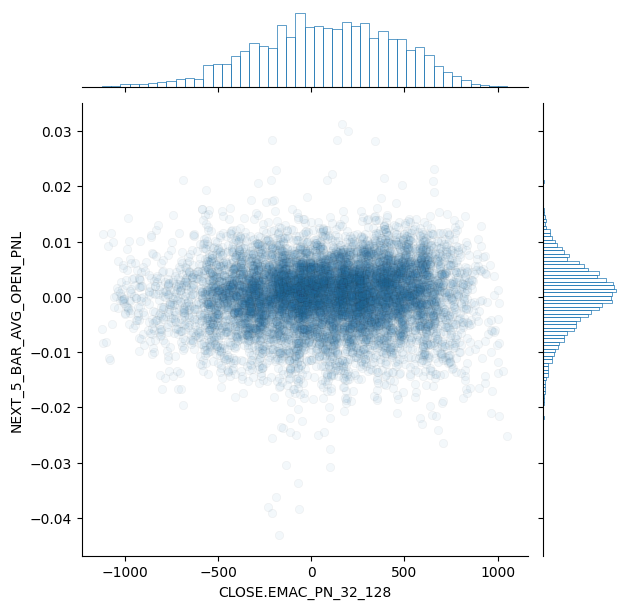

In [35]:
# g = sns.JointGrid(data=final_df, x=x_axis_col_name, y=y_axis_col_name)
# g.plot(sns.scatterplot, sns.histplot, alpha=.05, edgecolor=".2", linewidth=.5)
# g.lineplot(data=final_df, x=x_axis_col_name, y=x_axis_col_name)
# # sns.lineplot(x=x_pred, y=y_pred, ax=ax)

x, y = final_df[x_axis_col_name], final_df[y_axis_col_name]
g = sns.JointGrid()
sns.scatterplot(x=x, y=y, alpha=.05, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y)
# sns.lineplot(data=final_df, x=x_axis_col_name, y=x_axis_col_name, ax=g.ax_joint)


In [36]:
# print('{} mean: {} std: {}'.format(x_axis_col_name, 
#                                    final_df[x_axis_col_name].mean(), 
#                                    final_df[x_axis_col_name].std()))

# print('{} mean: {} std: {}'.format(y_axis_col_name, 
#                                    final_df[y_axis_col_name].mean(), 
#                                    final_df[y_axis_col_name].std()))

print(len(final_df))

10033


In [37]:
final_df.sort_values(by=[x_axis_col_name], inplace=True)
final_df['p_'+x_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)

final_df.sort_values(by=[y_axis_col_name], inplace=True)
final_df['p_'+y_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)



x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]
# plt.scatter(x, y, alpha=0.01)
# plt.xlabel(x_axis_col_name)
# plt.ylabel(y_axis_col_name)
# plt.show()

# g = sns.JointGrid()
# sns.scatterplot(x=x, y=y, alpha=.1, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
# sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x)
# sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y)
# sns.lineplot(data=final_df, x='p_'+x_axis_col_name, y='p_'+x_axis_col_name, ax=g.ax_joint)


In [39]:
bin_count = 10
bin_col_name_list = []

final_df.sort_index(inplace=True)

# bin x feature
x_bin_assignments, x_bin_edges = pd.qcut(final_df[x_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
x_bin_assignments_df = x_bin_assignments.to_frame()
x_bin_col_name = 'bins_' + x_axis_col_name
bin_col_name_list.append(x_bin_col_name)
x_bin_assignments_df.rename(columns={x_axis_col_name: x_bin_col_name}, inplace=True)

# bin y target
y_bin_assignments, y_bin_edges = pd.qcut(final_df[y_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
y_bin_assignments_df = y_bin_assignments.to_frame()
y_bin_col_name = 'bins_' + y_axis_col_name
bin_col_name_list.append(y_bin_col_name)
y_bin_assignments_df.rename(columns={y_axis_col_name: y_bin_col_name}, inplace=True)


# create data_frame with bins and target feature
binned_data_df = pd.concat([x_bin_assignments_df, y_bin_assignments_df], axis=1)
binned_data_df = binned_data_df.join(
    final_df[y_axis_col_name],
    how='right'
)
binned_data_df.dropna(axis=0, inplace=True)

# calculate the joint distribution
y_hats = binned_data_df.groupby(bin_col_name_list)[y_axis_col_name].count()
temp_y_hat_df = y_hats.to_frame()
temp_y_hat_df.columns = ['y_hat']
# y_hat_df = y_hat_df.reset_index()

y_hat_df = pd.DataFrame(index=create_y_hat_index(bin_col_name_list, bin_count))
y_hat_df['y_hat'] = temp_y_hat_df['y_hat']
y_hat_df = y_hat_df.reset_index()

<Axes: xlabel='p_CLOSE.EMAC_PN_32_128', ylabel='p_NEXT_5_BAR_AVG_OPEN_PNL'>

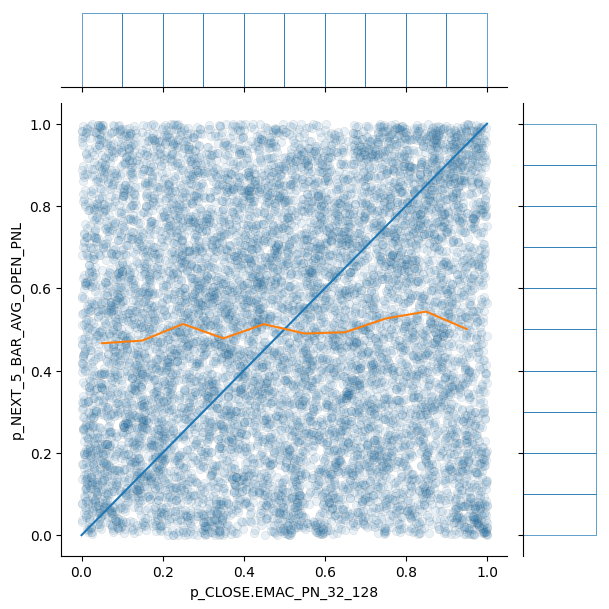

In [40]:
final_df[x_bin_col_name] = binned_data_df[x_bin_col_name]

# calculate the y_hat for each bin
y_hats = final_df.groupby(x_bin_col_name)['p_'+y_axis_col_name].mean()

g = sns.JointGrid()
sns.scatterplot(x=x, y=y, alpha=.1, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x, bins=10)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y, bins=10)
sns.lineplot(data=final_df, x='p_'+x_axis_col_name, y='p_'+x_axis_col_name, ax=g.ax_joint)
sns.lineplot(x=np.arange(0.05, 1.05, 0.1), y=y_hats, ax=g.ax_joint)


In [41]:
# x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]

# sns.histplot(
#     data=final_df, x='p_'+x_axis_col_name, y='p_'+y_axis_col_name, 
#     bins=10, cbar=True, stat='percent'
# )


In [42]:
y_hat_pivot_df = y_hat_df.pivot(index=bin_col_name_list[1], columns=bin_col_name_list[0], values='y_hat')
y_hat_pivot_df = y_hat_pivot_df.iloc[::-1]
print(y_hat_pivot_df)


bins_CLOSE.EMAC_PN_32_128       0    1    2    3    4    5    6    7    8    9
bins_NEXT_5_BAR_AVG_OPEN_PNL                                                  
9                              97   91  105   70   73   88   86  130  120  143
8                              79   89   91   90  126   97   84  104  131  112
7                              81   76  107   93   99  100  128  105  124   89
6                              93   92  111  101  126  112   94  107   87   80
5                             102  104  106  127  114   96   89   89   91   84
4                              95  101  113  106   96  109  115   96  105   67
3                             104  107  104  111  100   96  111   90  100   80
2                             107  129   85  108   92   97  104  101   81   98
1                             127  130   89   83   89   92  104   99   87  103
0                             119   84   92  111   86  116   88   82   77  148


In [43]:
# glue = sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
# sns.heatmap(y_hat_pivot_df)


In [44]:
# y_hat_df


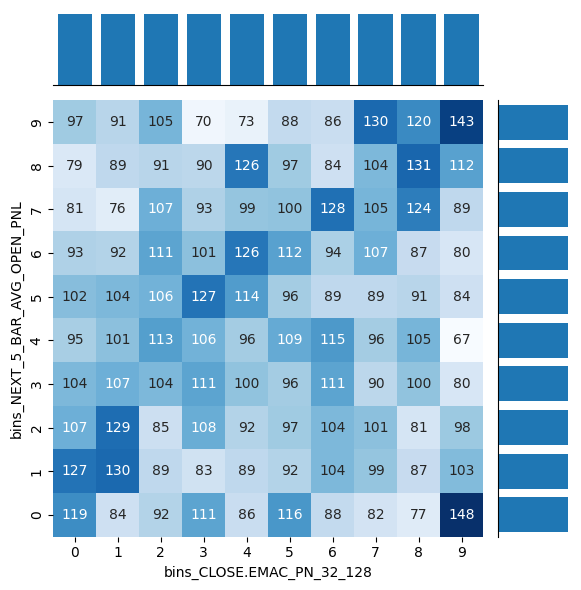

In [45]:
g = sns.jointplot(data=y_hat_df, 
                  x=bin_col_name_list[0], 
                  y=bin_col_name_list[1], 
                  kind='hist', 
                  bins=(len(bin_col_name_list[0]), len(bin_col_name_list[1])))
g.ax_marg_y.cla()
g.ax_marg_x.cla()
sns.heatmap(data=y_hat_pivot_df, ax=g.ax_joint, cbar=False, cmap='Blues', annot=True, fmt="d")
g.ax_marg_y.barh(np.arange(0.5, 10), y_hat_pivot_df.sum(axis=1)/len(bin_col_name_list[0]))
g.ax_marg_x.bar(np.arange(0.5, 10), y_hat_pivot_df.sum(axis=0)/len(bin_col_name_list[1]))

# remove ticks between heatmao and histograms
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# remove ticks showing the heights of the histograms
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

plt.show()

In [46]:
# sns.displot(y_hat_df, x="bins_CLOSE.PNL_N.EMA_32", y="bins_NEXT_20_BAR_AVG_PNL", binwidth=(2, .5), cbar=True)


In [47]:
final_df.columns[0:20]

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'SEC_EC', 'BAR_RAW_PNL', 'BAR_PNL',
       'BAR_RAW_OPEN_PNL', 'BAR_OPEN_PNL', 'NEXT_BAR_RAW_PNL', 'NEXT_BAR_PNL',
       'NEXT_BAR_RAW_OPEN_PNL', 'NEXT_BAR_OPEN_PNL',
       'NEXT_BAR_OPEN_PNL_VOL_BIASED', 'NEXT_5_BAR_AVG_PNL',
       'NEXT_5_BAR_AVG_OPEN_PNL', 'NEXT_5_BAR_AVG_OPEN_PNL_VOL_BIASED',
       'NEXT_10_BAR_AVG_PNL', 'NEXT_20_BAR_AVG_PNL', 'POS_SZ'],
      dtype='object')

In [48]:
# calculate the joint distribution
y_hats = binned_data_df.groupby(x_bin_col_name)[y_axis_col_name].mean()
temp_y_hat_df = y_hats.to_frame()
temp_y_hat_df.columns = ['y_hat']
# y_hat_df = y_hat_df.reset_index()

# y_hat_df = pd.DataFrame(index=create_y_hat_index(bin_col_name_list, bin_count))
y_hat_df = temp_y_hat_df
y_hat_df['y_hat'] = temp_y_hat_df['y_hat']
y_hat_df = y_hat_df.reset_index()

In [49]:
print(y_hat_df)


   bins_CLOSE.EMAC_PN_32_128     y_hat
0                          0 -0.000353
1                          1 -0.000203
2                          2  0.000291
3                          3 -0.000424
4                          4  0.000334
5                          5 -0.000192
6                          6  0.000075
7                          7  0.000755
8                          8  0.000944
9                          9 -0.000060


<Axes: xlabel='bins_CLOSE.EMAC_PN_32_128', ylabel='y_hat'>

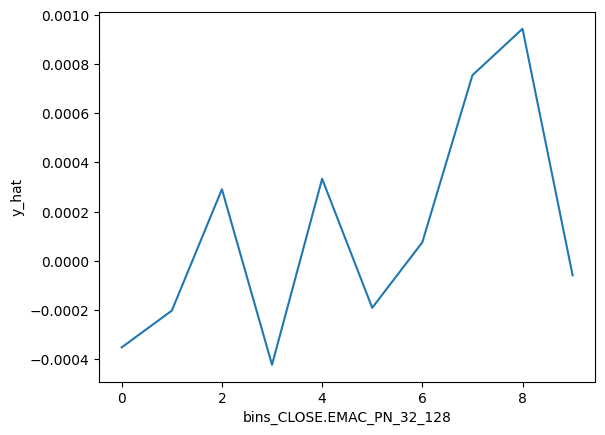

In [50]:
sns.lineplot(data=y_hat_df, x=x_bin_col_name, y='y_hat')

In [51]:
# print(binned_data_df)

bin_backtest_df = final_df[['CLOSE', 'NEXT_BAR_OPEN_PNL', x_axis_col_name]].copy()
bin_backtest_df.index = final_df.index
# print(bin_backtest_df)


In [52]:
bin_assignments = pd.cut(bin_backtest_df[x_axis_col_name],
                         bins=x_bin_edges,
                         labels=False,
                         include_lowest=True)
bin_backtest_df[x_bin_col_name] = bin_assignments
# print(bin_backtest_df)
# print(y_hat_df)

bin_backtest_df = bin_backtest_df.merge(y_hat_df, left_on=x_bin_col_name, right_on=x_bin_col_name)
bin_backtest_df.index = final_df.index


In [53]:
# print(bin_backtest_df)



In [54]:
bin_backtest_df['bin_model_returns'] = bin_backtest_df['NEXT_BAR_OPEN_PNL'] * bin_backtest_df['y_hat']
bin_model_ann_vol = 16 * bin_backtest_df['bin_model_returns'].std()
bin_model_vol_mult = 0.2 / bin_model_ann_vol
bin_backtest_df['bin_model_returns'] = bin_model_vol_mult * bin_backtest_df['bin_model_returns']
bin_model_sr = 252 * bin_backtest_df['bin_model_returns'].mean() / 0.2

bin_backtest_df['linear_model_returns'] = bin_backtest_df['NEXT_BAR_OPEN_PNL'] * bin_backtest_df[x_axis_col_name]
lin_model_ann_vol = 16 * bin_backtest_df['linear_model_returns'].std()
lin_model_vol_mult = 0.2 / lin_model_ann_vol
bin_backtest_df['linear_model_returns'] = lin_model_vol_mult * bin_backtest_df['linear_model_returns']
lin_model_sr = 252 * bin_backtest_df['linear_model_returns'].mean() / 0.2

def binary_classifier(row):
    if row[x_axis_col_name] > 0:
        val = 1
    elif row[x_axis_col_name] < 0:
        val = -1
    else:
        val = 0
    return val
class_col_name = '{}_class'.format(x_axis_col_name)
bin_backtest_df[class_col_name] = bin_backtest_df.apply(binary_classifier, axis=1)
bin_backtest_df['class_model_returns'] = bin_backtest_df['NEXT_BAR_OPEN_PNL'] * bin_backtest_df[class_col_name]
class_model_ann_vol = 16 * bin_backtest_df['class_model_returns'].std()
class_model_vol_mult = 0.2 / class_model_ann_vol
bin_backtest_df['class_model_returns'] = class_model_vol_mult * bin_backtest_df['class_model_returns']
class_model_sr = 252 * bin_backtest_df['class_model_returns'].mean() / 0.2

bin_backtest_df['bin_model_pnl'] = bin_backtest_df['bin_model_returns'].cumsum()
bin_backtest_df['linear_model_pnl'] = bin_backtest_df['linear_model_returns'].cumsum()
bin_backtest_df['class_model_pnl'] = bin_backtest_df['class_model_returns'].cumsum()
bin_backtest_df['bh_pnl'] = bin_backtest_df['NEXT_BAR_OPEN_PNL'].cumsum()

# print(bin_backtest_df)

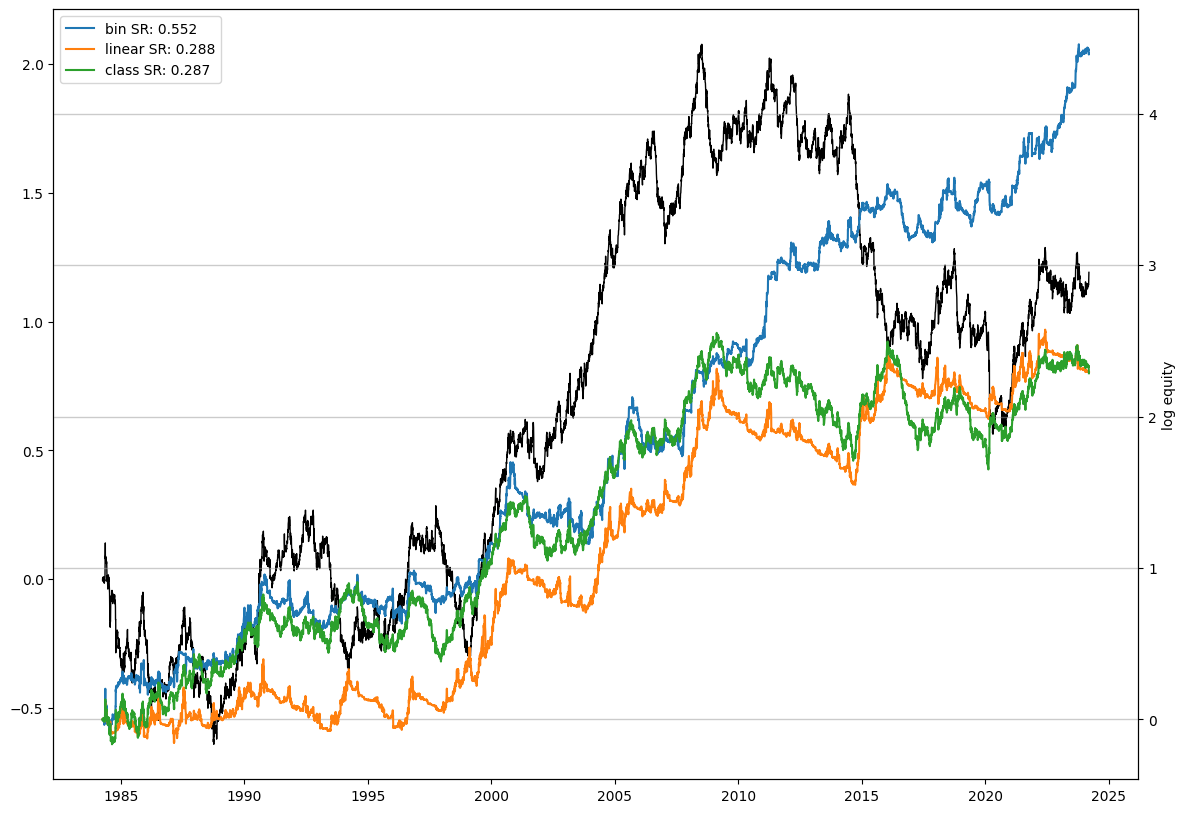

In [55]:

fig, ax1 = plt.subplots(figsize=(14, 10))
# plt.title( '{}: Stage Two Model SR: {:4.3f}'.format(symbol, stage_2_sr), fontsize=15)

ax1.plot(bin_backtest_df['bh_pnl'], color='black', linewidth='1')

ax2 = ax1.twinx()
ax2.plot(bin_backtest_df['bin_model_pnl'], label='{} SR: {:4.3f}'.format('bin', bin_model_sr))
ax2.plot(bin_backtest_df['linear_model_pnl'], label='{} SR: {:4.3f}'.format('linear', lin_model_sr))
ax2.plot(bin_backtest_df['class_model_pnl'], label='{} SR: {:4.3f}'.format('class', class_model_sr))

plt.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)
plt.ylabel("log equity")
plt.legend()
plt.show()
# fig.savefig('{0}/{1}/{2}/{3}/{3}.stage_two.{4}.equity.png'
#             .format(osprey_experiment_dir, experiment_name, asset_class, symbol, name_str))
plt.close(fig)
